In [1]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

# Load CSV files into DataFrames
adm_ref_entite = pd.read_csv('adm_ref_entite.csv')
pe_prd_declarationpeche = pd.read_csv('pe_prd_declarationpeche.csv')
pe_prd_sourceespdc = pd.read_csv('pe_prd_sourceespdc.csv')
pm_ref_espece = pd.read_csv('pm_ref_espece.csv')

# Initialize DuckDB in-memory connection
con = duckdb.connect(database=':memory:')

# Register DataFrames as tables
con.register('adm_ref_entite', adm_ref_entite)
con.register('pe_prd_declarationpeche', pe_prd_declarationpeche)
con.register('pe_prd_sourceespdc', pe_prd_sourceespdc)
con.register('pm_ref_espece', pm_ref_espece)


In [2]:
# Filtres Utilisateur - Modifier manuellement
start_date = '2025-06-01'       # Necessaire
end_date = '2025-07-20'         # Necessaire
selected_entity = '14'          # Necessaire
selected_port = ''              # Optionel
selected_pda_code = ''       # Optionel

# Validation Port appartenant a une entite. S'il n'appartient pas, filtre port ignoré.
if selected_port and not selected_port.startswith(selected_entity):
    print(f"Le port '{selected_port}' ne correspond pas à l'entité '{selected_entity}'. Filtre port ignoré.")
    selected_port = None
else:
    print(f"Filtre port activé : {selected_port if selected_port else 'Aucun'}")

print("Filtres utilisés :")
print(f"- Entité : {selected_entity}")
print(f"- Port : {selected_port if selected_port else 'Aucun (ignoré)'}")
print(f"- Code PDA : {selected_pda_code if selected_pda_code else 'Aucun (tous)'}")
print(f"- Période : du {start_date} au {end_date}")


Filtre port activé : Aucun
Filtres utilisés :
- Entité : 14
- Port : Aucun (ignoré)
- Code PDA : Aucun (tous)
- Période : du 2025-06-01 au 2025-07-20


In [3]:
def use_case_1_pda_precis(start_date, end_date, selected_pda_code):
    if not selected_pda_code:
        print("Aucun PDA selectione.")
        return

    print("Cas d'usage #1 : Nombre déclarations pour un PDA précis avec filtre période")
    query = f"""
    SELECT COUNT(DISTINCT a.NUMEROVISA) AS total_declarations_distinct
    FROM pe_prd_declarationpeche a
    INNER JOIN pe_prd_sourceespdc b ON a.id = b.id_refdeclaration
    INNER JOIN pm_ref_espece c ON c.id = b.id_refespece
    WHERE a.NUMEROVISA LIKE '%{selected_pda_code}%'
      AND CAST(a.DATE_DECLARATION AS DATE) BETWEEN DATE '{start_date}' AND DATE '{end_date}'
    """
    df = con.execute(query).fetchdf()
    print(df)

In [4]:
def use_case_2_ports_periode(start_date, end_date, selected_entity, selected_port, selected_pda_code):
    if selected_port or selected_pda_code:
        print("Filtres pda et port actifs, skipping use_case_2_ports_periode.")
        return

    print("Cas d'usage #2 : Nombre déclarations dans différents ports avec filtre période")
    query = f"""
    SELECT e.ENTITE_CODE AS ENTITE_CODE,
           e.ENTITE_NOM AS ENTITE_NOM,
           COUNT(DISTINCT CASE
               WHEN regexp_matches(SUBSTR(a.NUMEROVISA, POSITION('PDA' IN a.NUMEROVISA) + 3, 3), '^[0-9]+$')
               THEN a.id END) AS NOMBRE_DECLARATIONS_NEW_PDA
    FROM pe_prd_declarationpeche a
    INNER JOIN adm_ref_entite e ON e.ENTITE_CODE = a.ENTITE_CODE
    WHERE a.NUMEROVISA LIKE '%PDA%'
      AND POSITION('PDA' IN a.NUMEROVISA) > 0
      AND CAST(a.DATE_DECLARATION AS DATE) BETWEEN DATE '{start_date}' AND DATE '{end_date}'
    GROUP BY e.ENTITE_CODE, e.ENTITE_NOM
    ORDER BY e.ENTITE_CODE
    """
    df = con.execute(query).fetchdf()
    print(df)
    df.plot(kind='bar', x='ENTITE_NOM', y='NOMBRE_DECLARATIONS_NEW_PDA', legend=False, title='Nombre déclarations par port')
    plt.show()


In [5]:
def use_case_3_declarations_par_mois(start_date, end_date, selected_entity):
    print("Cas d'usage #3 : Nombre déclarations par mois avec filtre période")
    query = f"""
    SELECT e.ENTITE_CODE AS ENTITE_CODE,
           e.ENTITE_NOM AS ENTITE_NOM,
           date_part('month', CAST(a.DATE_DECLARATION AS DATE)) AS MOIS,
           COUNT(DISTINCT CASE
               WHEN regexp_matches(SUBSTR(a.NUMEROVISA, POSITION('PDA' IN a.NUMEROVISA) + 3, 3), '^[0-9]+$')
               THEN a.id END) AS NOMBRE_DECLARATIONS_NEW_PDA
    FROM pe_prd_declarationpeche a
    INNER JOIN adm_ref_entite e ON e.ENTITE_CODE = a.ENTITE_CODE
    WHERE a.NUMEROVISA LIKE '%PDA%'
      AND POSITION('PDA' IN a.NUMEROVISA) > 0
      AND CAST(a.DATE_DECLARATION AS DATE) BETWEEN DATE '{start_date}' AND DATE '{end_date}'
      AND e.ENTITE_CODE LIKE '{selected_entity}%'
    GROUP BY e.ENTITE_CODE, e.ENTITE_NOM, MOIS
    ORDER BY e.ENTITE_CODE, MOIS
    """
    df = con.execute(query).fetchdf()
    print(df)
    df.pivot(index='MOIS', columns='ENTITE_NOM', values='NOMBRE_DECLARATIONS_NEW_PDA').plot(kind='bar', title='Déclarations par mois')
    plt.show()


In [6]:
def use_case_5_port_precis(start_date, end_date, selected_port):
    if not selected_port:
        print("Aucun port selectione")
        return

    print("Cas d'usage #5 : Nombre déclarations dans un port précis dans une période précise")
    query = f"""
    SELECT e.ENTITE_CODE,
           e.ENTITE_NOM,
           COUNT(DISTINCT CASE
               WHEN regexp_matches(SUBSTR(a.NUMEROVISA, POSITION('PDA' IN a.NUMEROVISA) + 3, 3), '^[0-9]+$')
               THEN a.id END) AS NOMBRE_DECLARATIONS_NEW_PDA
    FROM pe_prd_declarationpeche a
    INNER JOIN adm_ref_entite e ON e.ENTITE_CODE = a.ENTITE_CODE
    WHERE a.NUMEROVISA LIKE '%PDA%'
      AND POSITION('PDA' IN a.NUMEROVISA) > 0
      AND CAST(a.DATE_DECLARATION AS DATE) BETWEEN DATE '{start_date}' AND DATE '{end_date}'
      AND e.ENTITE_CODE = '{selected_port}'
    GROUP BY e.ENTITE_CODE, e.ENTITE_NOM
    ORDER BY e.ENTITE_CODE
    """
    df = con.execute(query).fetchdf()
    print(df)

    if df.empty:
        print("Aucun résultat trouvé pour ce port et cette période.")
        return

    df.plot(kind='bar', x='ENTITE_NOM', y='NOMBRE_DECLARATIONS_NEW_PDA', legend=False, title='Nombre déclarations port précis')
    plt.show()


In [7]:
def use_case_7_entite_mere(start_date, end_date, selected_entity):
    print("Cas d'usage #7 : Nombre déclarations dans entités mères avec filtre période")
    query = f"""
    SELECT entite_mere.ENTITE_CODE AS ENTITE_MERE_CODE,
           entite_mere.ENTITE_NOM AS ENTITE_MERE_NOM,
           COUNT(DISTINCT CASE
               WHEN regexp_matches(SUBSTR(a.NUMEROVISA, POSITION('PDA' IN a.NUMEROVISA) + 3, 3), '^[0-9]+$')
               THEN a.id END) AS NOMBRE_DECLARATIONS_NEW_PDA
    FROM pe_prd_declarationpeche a
    INNER JOIN adm_ref_entite e ON e.ENTITE_CODE = a.ENTITE_CODE
    INNER JOIN adm_ref_entite entite_mere ON entite_mere.ENTITE_CODE = regexp_extract(e.ENTITE_CODE, '^(\\d+)', 1)
    WHERE CAST(a.DATE_DECLARATION AS DATE) BETWEEN DATE '{start_date}' AND DATE '{end_date}'
      AND e.ENTITE_CODE LIKE '{selected_entity}%'
    GROUP BY entite_mere.ENTITE_CODE, entite_mere.ENTITE_NOM
    ORDER BY entite_mere.ENTITE_CODE
    """
    df = con.execute(query).fetchdf()
    print(df)
    if df.empty or df['NOMBRE_DECLARATIONS_NEW_PDA'].sum() == 0:
        print("Aucune déclaration trouvée pour les entités mères dans cette période.")
        return
    df.plot(kind='bar', x='ENTITE_MERE_NOM', y='NOMBRE_DECLARATIONS_NEW_PDA', legend=False, title='Nombre déclarations entité mère')
    plt.show()


Vue complète de l'entité : ports, mois, entité mère
Cas d'usage #2 : Nombre déclarations dans différents ports avec filtre période
   ENTITE_CODE      ENTITE_NOM  NOMBRE_DECLARATIONS_NEW_PDA
0           10  ENTITE_MERE_10                            7
1         10/1    PORT_1_OF_10                           10
2         10/2    PORT_2_OF_10                            5
3         10/3    PORT_3_OF_10                            4
4           11  ENTITE_MERE_11                            7
5         11/1    PORT_1_OF_11                            8
6         11/2    PORT_2_OF_11                            4
7         11/3    PORT_3_OF_11                            5
8           12  ENTITE_MERE_12                            5
9         12/1    PORT_1_OF_12                            7
10        12/2    PORT_2_OF_12                            3
11        12/3    PORT_3_OF_12                            6
12          13  ENTITE_MERE_13                            2
13        13/1    PORT_1_OF_1

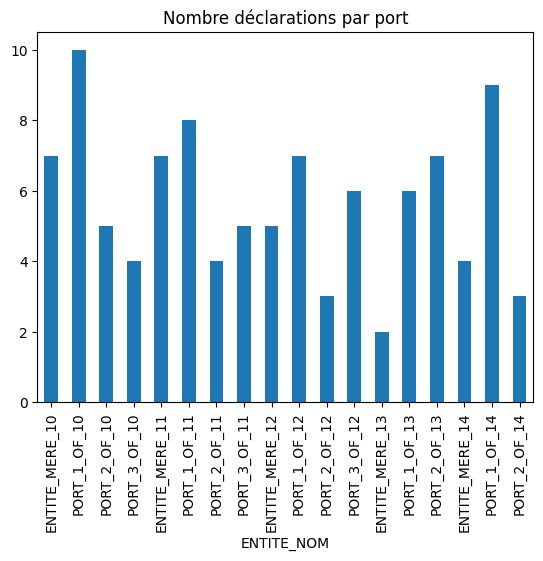

Cas d'usage #3 : Nombre déclarations par mois avec filtre période
  ENTITE_CODE      ENTITE_NOM  MOIS  NOMBRE_DECLARATIONS_NEW_PDA
0          14  ENTITE_MERE_14     6                            3
1          14  ENTITE_MERE_14     7                            1
2        14/1    PORT_1_OF_14     6                            4
3        14/1    PORT_1_OF_14     7                            5
4        14/2    PORT_2_OF_14     6                            1
5        14/2    PORT_2_OF_14     7                            2


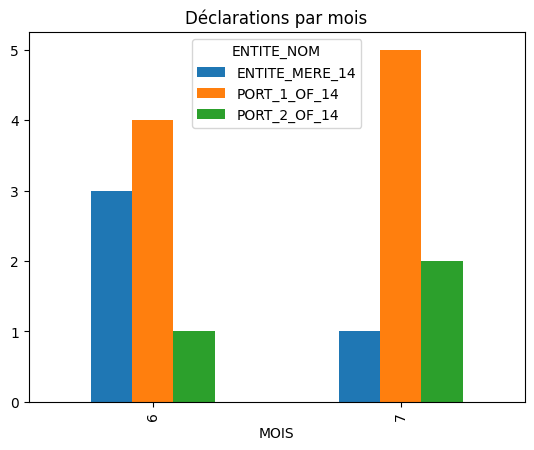

Cas d'usage #7 : Nombre déclarations dans entités mères avec filtre période
  ENTITE_MERE_CODE ENTITE_MERE_NOM  NOMBRE_DECLARATIONS_NEW_PDA
0               14  ENTITE_MERE_14                           16


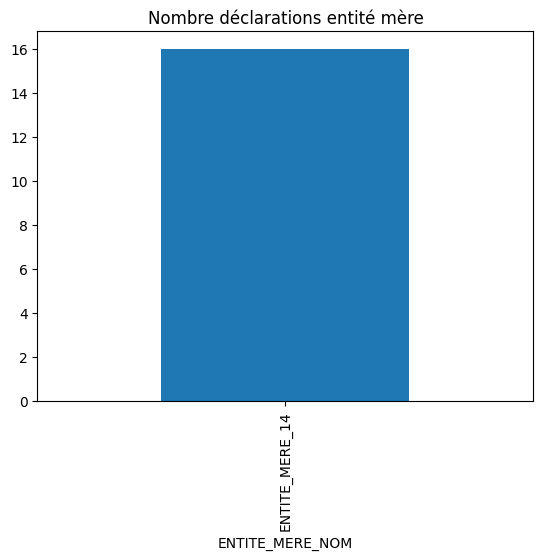

In [8]:
# Cas d'exécution basé sur les filtres
if selected_pda_code:
    # Cas #1 : PDA spécifique
    use_case_1_pda_precis(start_date, end_date, selected_pda_code)

elif selected_port:
    # Cas #5 : Port spécifique
    use_case_5_port_precis(start_date, end_date, selected_port)

elif selected_entity:
    # Cas #2, #3, #7 Analyse globale entité (aucun port ni PDA précisé)
    print("Vue complète de l'entité : ports, mois, entité mère")
    use_case_2_ports_periode(start_date, end_date, selected_entity, selected_port, selected_pda_code)
    use_case_3_declarations_par_mois(start_date, end_date, selected_entity)
    use_case_7_entite_mere(start_date, end_date, selected_entity)

else:
    # Aucun filtre essentiel
    print("L'entité est obligatoire. Veuillez sélectionner une entité.")